In [45]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
# %matplotlib inline
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, multiply, GlobalAveragePooling2D, Reshape, GlobalMaxPooling2D, Add, Activation
from tensorflow.keras.layers import Permute, Conv2D, Concatenate, Lambda
import tensorflow.keras.layers as KL

In [46]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img
def normal(img):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    return img
def load_image(img_path):
    img = read_png(img_path)
    img = normal(img)
    return img

In [47]:
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [48]:
test_images = glob.glob('D:\\SAT\\DoubleAttention\\test_img\\*.png')
test_anno = glob.glob('D:\\SAT\\DoubleAttention\\test_label\\*.png')

In [49]:
class ChannelAttention(keras.layers.Layer):
    def __init__(self, channel, reduction_ratio=0.125):
        super(ChannelAttention, self).__init__()
        self.maxpool_channel = KL.GlobalMaxPooling2D()
        self.avgpool_channel = KL.GlobalAvgPool2D()
        self.Dense_One = KL.Dense(units=int(channel * reduction_ratio), activation='relu', kernel_initializer='he_normal')
        self.Dense_Two = KL.Dense(units=int(channel), activation='relu', kernel_initializer='he_normal')

        self.reshpe1 = KL.Reshape(target_shape=(1, 1, int(channel)))
        self.reshpe2 = KL.Reshape(target_shape=(1, 1, int(channel)))
        self.Add = KL.Add()
        self.multi = KL.Multiply()

    def forward(self, x):
        mlp_1_max = self.Dense_One(self.maxpool_channel(x))
        mlp_2_max = self.Dense_Two(mlp_1_max)
        mlp_2_max = self.reshpe1(mlp_2_max)
       # avg path
        mlp_1_avg = self.Dense_One(self.avgpool_channel(x))
        mlp_2_avg = self.Dense_Two(mlp_1_avg)
        mlp_2_avg = self.reshpe2(mlp_2_avg)
        channel_attention_feature = self.Add([mlp_2_max, mlp_2_avg])
        return self.multi([channel_attention_feature, x])

class SpatialAttention(keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.maxpool_spatial = KL.Lambda(lambda x: K.max(x, axis=3, keepdims=True))
        self.avgpool_spatial = KL.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))
        self.max_avg_pool_spatial = KL.Concatenate(axis=3)
        self.res = KL.Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def forward(self, x):
        maxpool_ = self.maxpool_spatial(x)
        avgpool_ = self.avgpool_spatial(x)
        max_avg_pool_ = self.max_avg_pool_spatial([maxpool_, avgpool_])
        return self.res(max_avg_pool_)

class CBAM(keras.layers.Layer):
    def __init__(self, channel, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channel)
        self.spatial_attention = SpatialAttention()
        self.multi = KL.Multiply()
        self.add = KL.Add()
    def forward(self, input_xs):
        channel_refined_feature = self.channel_attention(input_xs)
        spatial_attention_feature = self.spatial_attention(channel_refined_feature)
        refined_feature = self.multi([channel_refined_feature, spatial_attention_feature])
        return self.add([refined_feature, input_xs])

In [50]:
class PAM(keras.layers.Layer):
    def __init__(self, dim,
                 gamma_initializer=tf.zeros_initializer(),
                 gamma_regularizer=None,
                 gamma_constraint=None,
                 **kwargs):
        super(PAM, self).__init__(**kwargs)
        self.gamma_initializer = gamma_initializer
        self.gamma_regularizer = gamma_regularizer
        self.gamma_constraint = gamma_constraint

        self.f = keras.layers.Conv2D(dim // 8, 1, use_bias=False, kernel_initializer='he_normal')
        self.h = keras.layers.Conv2D(dim // 8, 1, use_bias=False, kernel_initializer='he_normal')
        self.w = keras.layers.Conv2D(dim, 1, use_bias=False, kernel_initializer='he_normal')

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(1, ),
                                     initializer=self.gamma_initializer,
                                     name='gamma',
                                     regularizer=self.gamma_regularizer,
                                     constraint=self.gamma_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, input):
        input_shape = input.get_shape().as_list()
        _, h, w, filters = input_shape

        b = self.f(input)
        c = self.h(input)
        d = self.w(input)

        vec_b = K.reshape(b, (-1, h * w, filters // 8))
        vec_cT = tf.transpose(K.reshape(c, (-1, h * w, filters // 8)), (0, 2, 1))
        bcT = K.batch_dot(vec_b, vec_cT)
        softmax_bcT = Activation('softmax')(bcT)
        vec_d = K.reshape(d, (-1, h * w, filters))
        bcTd = K.batch_dot(softmax_bcT, vec_d)
        bcTd = K.reshape(bcTd, (-1, h, w, filters))

        out = self.gamma*bcTd + input
        return out


In [51]:
class Downsample(keras.layers.Layer):
    def __init__(self, units):
        super(Downsample, self).__init__()
        self.conv1 = keras.layers.Conv2D(units, kernel_size=3, padding='same')
        self.conv2 = keras.layers.Conv2D(units, kernel_size=3, padding='same')
        self.pool = keras.layers.MaxPooling2D()
    def call(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        return x
class Upsample(keras.layers.Layer):
    def __init__(self, unit):
        super(Upsample, self).__init__()
        self.conv1 = keras.layers.Conv2D(unit, kernel_size=3, padding='same')
        self.conv2 = keras.layers.Conv2D(unit, kernel_size=3, padding='same')
        self.deconv = keras.layers.Conv2DTranspose(unit // 2,
                                                   kernel_size=3,
                                                   strides=2,
                                                   padding='same')

    def call(self, x, is_pool=True):
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.deconv(x)
        x = tf.nn.relu(x)
        return x

In [52]:
class Net(keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.down1 = Downsample(64)
        self.cbam1 = CBAM(64)
        self.down2 = Downsample(128)
        self.cbam2 = CBAM(128)
        self.down3 = Downsample(256)
        self.cbam3 = CBAM(256)
        self.down4 = Downsample(512)
        self.cbam4 = CBAM(512)
        self.down5 = Downsample(1024)

        self.down1_ = Downsample(64)
        self.down2_ = Downsample(128)
        self.down3_ = Downsample(256)
        self.csa_3 = PAM(256)
        self.down4_ = Downsample(512)
        self.csa_4 = PAM(512)
        self.down5_ = Downsample(1024)

        self.multi_3 = KL.Add()
        self.multi_4 = KL.Add()
        self.multi_5 = KL.Add()

        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)

        self.conv_last = Downsample(64)

        self.up = keras.layers.Conv2DTranspose(512,
                                               kernel_size=3,
                                               strides=2,
                                               padding='same')

        self.last = keras.layers.Conv2D(5,
                                        kernel_size=1,
                                        padding='same')

    def call(self, x):
        x1_1 = self.down1(x, is_pool=False)  # 256*256*64
        x1 = self.cbam1(x1_1)
        x2_1 = self.down2(x1)  # 128*128*128
        x2 = self.cbam2(x2_1)
        x3_1 = self.down3(x2)  # 64*64*256
        x3 = self.cbam3(x3_1)
        x4_1 = self.down4(x3)  # 32*32*512
        x4 = self.cbam4(x4_1)
        x5 = self.down5(x4)  # 16*16*1024

        x1_ = self.down1_(x, is_pool=False)
        x2_ = self.down2(x1_)
        x3_2= self.down3(x2_)
        x3_ = self.csa_3(x3_2)
        x4_2 = self.down4(x3_)
        x4_ = self.csa_4(x4_2)
        x5_ = self.down5(x4_)

        x5 = tf.concat([x5, x5_], axis=-1)
        x5 = tf.keras.layers.Dropout(0.3)(x5)
        x5 = self.up(x5)  # 32*32*512

        x4 = tf.concat([x4, x4_], axis = -1)
        x5 = tf.concat([x4, x5], axis=-1)  # 32*32*1024
        x5 = self.up1(x5)  # 64*64*256

        x3 = tf.concat([x3, x3_], axis=-1)
        x5 = tf.concat([x3, x5], axis=-1)  # 64*64*512
        x5 = self.up2(x5)  # 128*128*128

        x5 = tf.concat([x2, x5], axis=-1)  # 128*128*256
        x5 = self.up3(x5)  # 256*256*64

        x5 = tf.concat([x1, x5], axis=-1)  # 256*256*128

        x5 = self.conv_last(x5, is_pool=False)  # 256*256*64

        x5 = self.last(x5)  # 256*256*3
        return x5


In [53]:
model = Net()
input_shape=(None, 256, 256, 3)
model.build(input_shape)

In [54]:
model.load_weights(r"tf_doubleattention50_concat.h5")

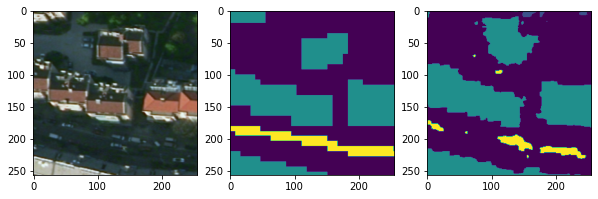

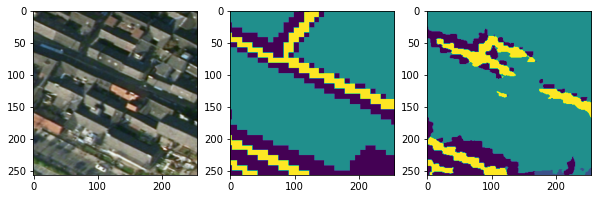

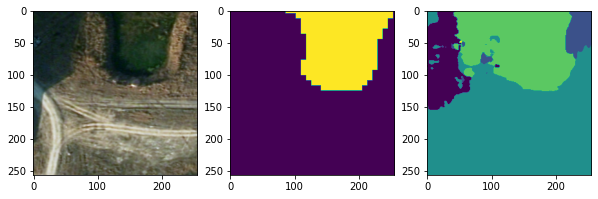

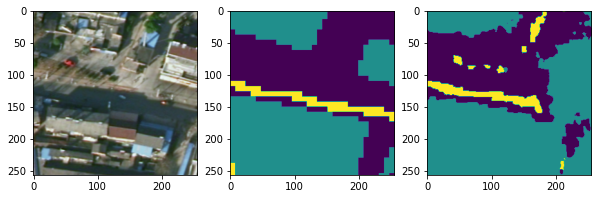

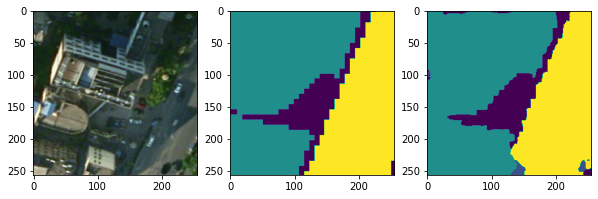

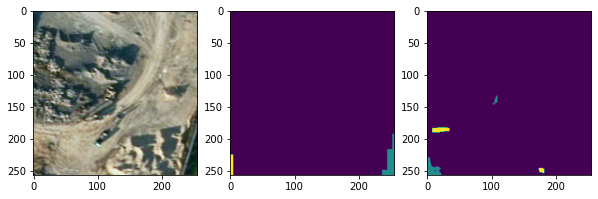

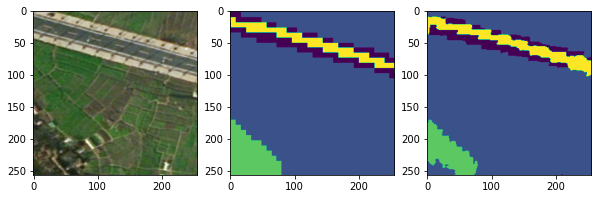

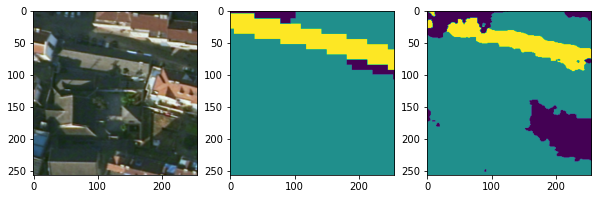

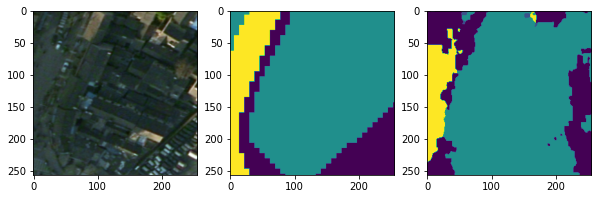

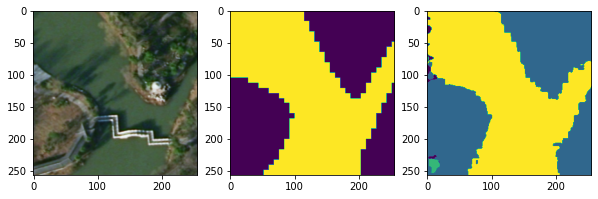

In [55]:
num =1
for i in range(len(test_images)):
    img = load_image(test_images[i])
    mask = read_png_label(test_anno[i])
    
    mask_image = tf.expand_dims(img, 0)
    
    pred_mask= model(mask_image)
    pred_mask = tf.squeeze(pred_mask)
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    gen_img = tf.cast(pred_mask, dtype=tf.uint8)
    gen_img = tf.image.encode_jpeg(gen_img)
    gen_img_path = 'D:\\python37\\DoubleAttention\\result\\Double\\' + test_images[i].split('\\')[-1]
    with tf.io.gfile.GFile(gen_img_path, 'wb') as file:
        file.write(gen_img.numpy())
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))